In [1]:
%matplotlib inline
from src.pgm import draw
from src.data import discretize, get_f1_score

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer

from pgmpy.models import BayesianModel

In [2]:
df = pd.read_csv("dataset/diabetes.csv")
df.loc[:,'Glucose':'BMI'] = df.loc[:,'Glucose':'BMI'].replace(0,np.nan)
df = df.fillna(df.mean()).astype({
    "Pregnancies": "int32",
    "Glucose": "int32",
    "BloodPressure": "int32",
    "SkinThickness": "int32",
    "Insulin": "int32",
    "BMI": "int32",
    "DiabetesPedigreeFunction": "float",
    "Age": "int32",
    "Outcome": "category"
})
kbd = KBinsDiscretizer(n_bins=5, encode='ordinal').fit(df.drop(columns="Outcome"))
df = discretize(kbd, df)
train, test = train_test_split(df, test_size=0.15, stratify=df["Outcome"], random_state=42)

/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 3 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/sklearn/preprocessing/_discretization.py:220: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn('Bins whose width are too small (i.e., <= '


# Model uproszczony
Rozważamy tylko zmienne:
- Glucose
- Insulin
- SkinThickness
- Outcome

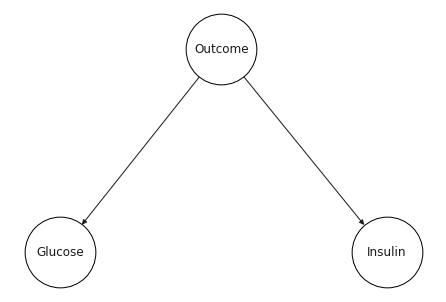

In [37]:
bn = BayesianModel([
    ("Outcome", "Glucose"),
    ("Outcome", "Insulin"),
])
bn.fit(train[["Glucose", "Insulin", "Outcome"]])
draw(bn)

In [38]:
y_pred = bn.predict(test[["Glucose", "Insulin"]])
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

100%|██████████| 21/21 [00:00<00:00, 7193.17it/s]F1-score: 0.77
              precision    recall  f1-score   support

           0       0.92      0.81      0.86        72
           1       0.70      0.86      0.77        37

    accuracy                           0.83       109
   macro avg       0.81      0.84      0.82       109
weighted avg       0.84      0.83      0.83       109




# Pełen model
Wpierw badamy wyniki zwracane przez modele, których struktura wynika ze zgromadzonej wiedzy o problemie.
Wiemy, że cukrzycy 

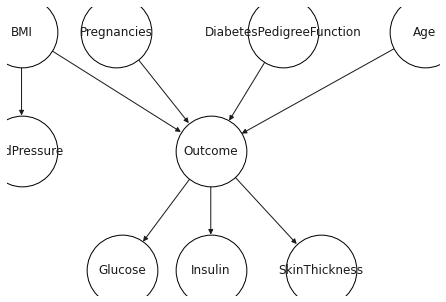

100%|██████████| 109/109 [00:01<00:00, 59.41it/s]
F1-score: 0.67
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        72
           1       0.61      0.76      0.67        37

    accuracy                           0.75       109
   macro avg       0.73      0.75      0.74       109
weighted avg       0.77      0.75      0.76       109



In [39]:
bn = BayesianModel([
    ("BMI", "BloodPressure"),
    ("BMI", "Outcome"),
    ("Pregnancies", "Outcome"),
    ("DiabetesPedigreeFunction", "Outcome"),
    ("Age", "Outcome"),
    ("Outcome", "Glucose"),
    ("Outcome", "Insulin"),
    ("Outcome", "SkinThickness"),
])
bn.fit(train)
draw(bn)
y_pred = bn.predict(test.drop(columns="Outcome"))
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

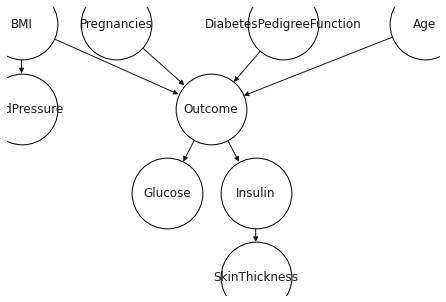

100%|██████████| 115/115 [00:01<00:00, 89.38it/s]
F1-score: 0.60
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        76
           1       0.60      0.60      0.60        40

    accuracy                           0.72       116
   macro avg       0.69      0.69      0.69       116
weighted avg       0.72      0.72      0.72       116



In [6]:
bn = BayesianModel([
    ("BMI", "BloodPressure"),
    ("BMI", "Outcome"),
    ("Pregnancies", "Outcome"),
    ("DiabetesPedigreeFunction", "Outcome"),
    ("Age", "Outcome"),
    ("Outcome", "Glucose"),
    ("Outcome", "Insulin"),
    ("Insulin", "SkinThickness"),
])
bn.fit(train)
draw(bn)
y_pred = bn.predict(test.drop(columns="Outcome"))
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

# Poszukiwanie architektury grafu

  0%|          | 9/1000000 [00:00<25:49:02, 10.76it/s]


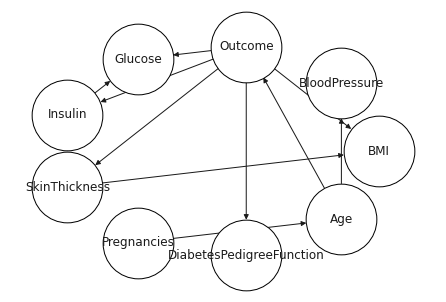

100%|██████████| 109/109 [00:00<00:00, 434.20it/s]
F1-score: 0.77
              precision    recall  f1-score   support

           0       0.91      0.82      0.86        72
           1       0.70      0.84      0.77        37

    accuracy                           0.83       109
   macro avg       0.81      0.83      0.81       109
weighted avg       0.84      0.83      0.83       109



In [40]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import K2Score


bn_hc = HillClimbSearch(df).estimate(
    scoring_method=K2Score(df),
    start_dag=BayesianModel(list(bn.edges)),
)
draw(bn_hc, layout="kamada_kawai_layout", scale=40);
model = bn_hc.copy()
model.fit(train)
y_pred = model.predict(test.drop(columns="Outcome"))
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

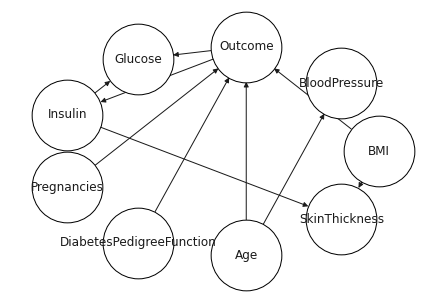

In [8]:
bn_hc.remove_edge("Outcome", "BMI")
bn_hc.add_edge("BMI", "Outcome")

bn_hc.remove_edge("SkinThickness", "Insulin")
bn_hc.add_edge("Insulin", "SkinThickness")

bn_hc.remove_edge("Outcome", "DiabetesPedigreeFunction")
bn_hc.add_edge("DiabetesPedigreeFunction", "Outcome")

bn_hc.remove_edge("Pregnancies", "Age")

draw(bn_hc, layout="kamada_kawai_layout", scale=40);

In [9]:
model = bn_hc.copy()
model.fit(train)
y_pred = model.predict(test.drop(columns="Outcome"))
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

100%|██████████| 115/115 [00:01<00:00, 62.77it/s]
F1-score: 0.59
              precision    recall  f1-score   support

           0       0.78      0.76      0.77        76
           1       0.57      0.60      0.59        40

    accuracy                           0.71       116
   macro avg       0.68      0.68      0.68       116
weighted avg       0.71      0.71      0.71       116



es
  warn(
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:644: UserWarning: Skipping the test SkinThickness ⟂ Outcome | Age=2, Insulin=3.0, Glucose=4.0. Not enough samples
  warn(
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:644: UserWarning: Skipping the test Age ⟂ Outcome | Glucose=2.0, Insulin=2.0, SkinThickness=3.0. Not enough samples
  warn(
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:644: UserWarning: Skipping the test SkinThickness ⟂ Outcome | Age=2, Insulin=4.0, Glucose=1.0. Not enough samples
  warn(
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:644: UserWarning: Skipping the test Glucose ⟂ Outcome | Age=2, Insulin=4.0, SkinThickness=1.0. Not enough samples
  warn(
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/pgmpy/estimators/CITests.py:644: UserWarning: Skipping the test Age ⟂ Outcome | Glucose=2.0,

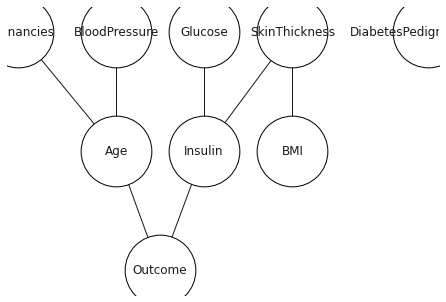

In [41]:
from pgmpy.estimators import PC
pc_est = PC(data=df)
skeleton_pc, separating_sets_pc = pc_est.build_skeleton(variant='parallel')
draw(skeleton_pc)

In [42]:
bn_pc = BayesianModel(list(skeleton_pc.edges))
bn_pc.add_nodes_from(bn)
bn_pc.fit(train)
y_pred = bn_pc.predict(test.drop(columns="Outcome"))
f1 = get_f1_score(
    y_true=test["Outcome"],
    y_pred=y_pred,
    verbose=2
)

100%|██████████| 109/109 [00:00<00:00, 329.30it/s]
F1-score: 0.79
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        72
           1       0.77      0.81      0.79        37

    accuracy                           0.85       109
   macro avg       0.83      0.84      0.84       109
weighted avg       0.86      0.85      0.85       109



# Missing values estimation

In [30]:
df = pd.read_csv("dataset/diabetes.csv").astype({
    "Pregnancies": "int32",
    "Glucose": "int32",
    "BloodPressure": "int32",
    "SkinThickness": "int32",
    "Insulin": "int32",
    "BMI": "int32",
    "DiabetesPedigreeFunction": "float",
    "Age": "int32",
    "Outcome": "category"
})
df.loc[:,'Glucose':'BMI'] = df.loc[:,'Glucose':'BMI'].replace(0,np.nan)
coplete_rows = df.dropna().index

kbd = KBinsDiscretizer(n_bins=5, encode='ordinal').fit(df.iloc[coplete_rows].drop(columns="Outcome"))
df.iloc[coplete_rows] = discretize(kbd, df.iloc[coplete_rows])
df.iloc[coplete_rows]
# df = df.fillna(df.mean()).astype({
#     "Pregnancies": "int32",
#     "Glucose": "int32",
#     "BloodPressure": "int32",
#     "SkinThickness": "int32",
#     "Insulin": "int32",
#     "BMI": "int32",
#     "DiabetesPedigreeFunction": "float",
#     "Age": "int32",
#     "Outcome": "category"
# })
# kbd = KBinsDiscretizer(n_bins=5, encode='ordinal').fit(df.drop(columns="Outcome"))
# df = discretize(kbd, df)
# train, test = train_test_split(df, test_size=0.15, stratify=df["Outcome"], random_state=42)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,1,0.0,1.0,1.0,1.0,1.0,0.0,0,0
4,0,3.0,0.0,3.0,3.0,4.0,4.0,3,1
6,3,0.0,0.0,3.0,1.0,2.0,0.0,2,1
8,2,4.0,2.0,4.0,4.0,1.0,0.0,4,1
13,1,4.0,1.0,1.0,4.0,1.0,2.0,4,1
...,...,...,...,...,...,...,...,...,...
753,0,4.0,4.0,4.0,4.0,4.0,0.0,2,1
755,1,3.0,4.0,4.0,2.0,3.0,4.0,3,1
760,2,0.0,0.0,2.0,0.0,1.0,4.0,0,0
763,4,1.0,3.0,4.0,3.0,2.0,0.0,4,0


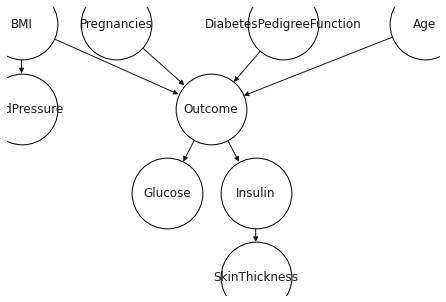

In [31]:
bn = BayesianModel([
    ("BMI", "BloodPressure"),
    ("BMI", "Outcome"),
    ("Pregnancies", "Outcome"),
    ("DiabetesPedigreeFunction", "Outcome"),
    ("Age", "Outcome"),
    ("Outcome", "Glucose"),
    ("Outcome", "Insulin"),
    ("Insulin", "SkinThickness"),
])
bn.fit(df.iloc[coplete_rows])
draw(bn)

In [32]:
def fix(df: pd.DataFrame, to_fix: pd.DataFrame):
    if to_fix.shape[0] == 0:
        print("Warning: No records in \"to_fix\"")
        return
    missings = to_fix.columns[to_fix.isna().any()].tolist()
    to_fix = to_fix.fillna(0)
    to_fix = discretize(kbd, to_fix)
    # df.loc[to_fix.index, [col for col in df.columns.tolist() if col not in ["Outcome"]] = 
    to_fix.loc[to_fix.index, missings] = bn.predict(to_fix.drop(columns=missings)).set_index(to_fix.index)
    df.loc[to_fix.index, :] = to_fix
    return df

In [33]:
to_fix = df[df["Glucose"].notna() & df["BloodPressure"].notna() &\
    df["BMI"].notna() & df["Insulin"].isna() & df["SkinThickness"].isna()]
fix(df, to_fix)

100%|██████████| 188/188 [00:05<00:00, 36.47it/s]


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.0,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.0,0.351,31,0
2,4,4.0,1.0,4.0,4.0,0.0,3.000,3,1
3,1,0.0,1.0,1.0,1.0,1.0,0.000,0,0
4,0,3.0,0.0,3.0,3.0,4.0,4.000,3,1
...,...,...,...,...,...,...,...,...,...
763,4,1.0,3.0,4.0,3.0,2.0,0.000,4,0
764,2,122.0,70.0,27.0,NaN,36.0,0.340,27,0
765,3,2.0,2.0,1.0,2.0,1.0,0.000,3,0
766,1,3.0,1.0,4.0,4.0,1.0,1.000,4,1


In [34]:
to_fix = df[df["Glucose"].notna() & df["BloodPressure"].notna() &\
    df["BMI"].notna() & df["Insulin"].notna() & df["SkinThickness"].isna()]
fix(df, to_fix)

In [35]:
to_fix = df[df["Glucose"].notna() & df["BloodPressure"].notna() &\
    df["BMI"].notna() & df["Insulin"].isna() & df["SkinThickness"].notna()]
fix(df, to_fix)

100%|██████████| 140/140 [00:01<00:00, 83.08it/s]


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,4,3.0,2.0,3.0,4.0,2.0,3.0,4,1
1,1,0.0,1.0,2.0,2.0,1.0,1.0,3,0
2,4,4.0,1.0,4.0,4.0,0.0,3.0,3,1
3,1,0.0,1.0,1.0,1.0,1.0,0.0,0,0
4,0,3.0,0.0,3.0,3.0,4.0,4.0,3,1
...,...,...,...,...,...,...,...,...,...
763,4,1.0,3.0,4.0,3.0,2.0,0.0,4,0
764,2,2.0,2.0,2.0,2.0,3.0,1.0,2,0
765,3,2.0,2.0,1.0,2.0,1.0,0.0,3,0
766,1,3.0,1.0,4.0,4.0,1.0,1.0,4,1


In [36]:
df = df.dropna()
train, test = train_test_split(df, test_size=0.15, stratify=df["Outcome"], random_state=42)

# Brudnopis

In [78]:
raise ValueError()

ValueError: 

In [29]:
def set_missing_values(x):
    x = pd.DataFrame([x], columns=df.columns.tolist())
    missings = x.columns[x.isna().any()].tolist()
    if len(missings) == 0:
        return df
    x = x.fillna(0)
    x.iloc[:, :-1] = kbd.transform(x.drop(columns="Outcome"))
    x.loc[:, missings] = bn.predict(x.drop(columns=missings))
    return x
fixed = df.apply(set_missing_values, axis=1)

100%|██████████| 1/1 [00:00<00:00, 981.12it/s]
